In [2]:
# Cell One
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import yfinance as yf
import re
from nltk.corpus import stopwords
import nltk
from google.colab import drive
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Cell Two

# Mount the drive
drive.mount('/content/drive', force_remount=True)

# Define the save path in Google Drive
save_path_parquet = '/content/drive/My Drive/news_data.parquet'
news_data = pd.read_parquet(save_path_parquet)

# Count the number of headlines for each ticker and display in descending order
ticker_headline_counts = news_data['stock'].value_counts()

# Filter tickers with at least 2000 headlines
filtered_tickers = ticker_headline_counts[ticker_headline_counts >= 2000]

# Define a function to download stock data
def fetch_stock_data(ticker):
    try:
        stock_data = yf.download(ticker, start='2009-02-13', end='2020-06-11')
        stock_data = stock_data.reset_index()
        stock_data.rename(columns={"Date": "date"}, inplace=True)
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        return stock_data
    except Exception:
        return None

# Attempt to fetch data for top 30 tickers with highest news occurrences
top_30_tickers = filtered_tickers.index[:30]
successful_tickers = []

for ticker in top_30_tickers:
    data = fetch_stock_data(ticker)
    if data is not None:
        successful_tickers.append(ticker)

# Select top 10 from successful tickers based on news occurrence
top_10_tickers = sorted(successful_tickers, key=lambda x: filtered_tickers[x], reverse=True)[:10]

# Process only the top 10 tickers
stock_data_dict = {}

for ticker in top_10_tickers:
    stock_data = fetch_stock_data(ticker)

    stock_data_dict[ticker] = stock_data

# Data processing: Aggregate news per ticker and filter by date
aggregated_news_per_ticker = news_data.groupby(['date', 'stock']).agg({'headline': ' '.join}).reset_index()
ticker_news_dict = {}

for ticker in top_10_tickers:
    ticker_news = aggregated_news_per_ticker[aggregated_news_per_ticker['stock'] == ticker]

    ticker_news = ticker_news.copy()
    ticker_news['date'] = pd.to_datetime(ticker_news['date'])

    # Ensuring common dates between stock data and news data
    common_dates = stock_data_dict[ticker][stock_data_dict[ticker]['date'].isin(ticker_news['date'])]
    filtered_news = ticker_news[ticker_news['date'].isin(common_dates['date'])]

    ticker_news_dict[ticker] = filtered_news



Mounted at /content/drive
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FCAU']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MYL']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['YHOO']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-02-13 -> 2020-06-11)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FCAU']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Cell Three

complete_data = pd.DataFrame()

# Loop over each filtered ticker and merge its stock data with its news data
for ticker in top_10_tickers:
    ticker_stock_data = stock_data_dict[ticker][['date', 'Open', 'Close']]
    ticker_news = ticker_news_dict[ticker][['date', 'headline']]
    merged_data = pd.merge(ticker_stock_data, ticker_news, on='date', how='inner')
    complete_data = pd.concat([complete_data, merged_data])

# Ensure that the resulting DataFrame is sorted by date and reset the index
complete_data = complete_data.sort_values(by='date').reset_index(drop=True)

# Create Labels (The market trend will be our target variable for regression)
complete_data['market trend'] = ((complete_data['Close'] - complete_data['Open']) / complete_data['Open']) * 100

# Data Inspection
print("\nOverview of Complete Data:")
print(complete_data.head())
print(complete_data.describe())

# Check for Missing Values
print("\nMissing Values:")
print(complete_data.isnull().sum())

# Check Distribution of 'market trend'
print("\nDistribution of Market Trend:")
print(complete_data['market trend'].describe())

# Convert headline to lowercase, remove non-word characters
complete_data['headline'] = complete_data['headline'].apply(lambda x: x.lower())
complete_data['headline'] = complete_data['headline'].apply(lambda x: re.sub(r'\W', ' ', x))

# Feature Extraction using the headlines
vectorizer = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(complete_data['headline']).toarray()

# Data Split using the market trend as the target
y = complete_data['market trend'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building for Regression

# Import Keras modules
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1

model = Sequential()

# Define L1 regularization strength
l1_value = 0.1

# Modify the model layers to include L1 regularization
model.add(Dense(128, input_dim=X.shape[1], activation='relu', kernel_regularizer=l1(l1_value)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(l1_value)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l1(l1_value)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output neuron for regression

# Set hyperparameters
learning_rate = 0.1
batch_size = 32

# Adam optimiser instantiation
opt = Adam(learning_rate=learning_rate)

# Model compilation for Regression
model.compile(loss='mse', optimizer=opt)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop])



Overview of Complete Data:
        date        Open       Close  \
0 2010-02-04   10.705000   10.580000   
1 2010-02-09  792.000000  776.799988   
2 2010-02-10  765.599976  767.200012   
3 2010-02-12   22.730000   22.870001   
4 2010-02-12   33.330002   34.200001   

                                    headline  market trend  
0  Alternative Investing in the 'New Normal'     -1.167679  
1            Rob's Wrap: OSIP, FXP, VSH, SLE     -1.919193  
2               Fitz Bits: IBM Is Firming Up      0.208991  
3             Avoid China and Brazil Tuesday      0.615932  
4    WFMI Preview: Focus Will Be on Expenses      2.610258  
              Open        Close  market trend
count  8419.000000  8419.000000   8419.000000
mean    105.070942   105.066819      0.025678
std     161.201049   161.223973      1.613562
min       9.875000     9.660000    -18.890360
25%      30.260000    30.260000     -0.719686
50%      52.599998    52.630001      0.036174
75%      95.899998    96.040001      0.7838

Average daily percentage change in stock prices: 2.57%
53/53 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 2.3980091376999755
Root Mean Squared Error (RMSE): 1.548550657130717
Mean Absolute Error (MAE): 1.065547442304701


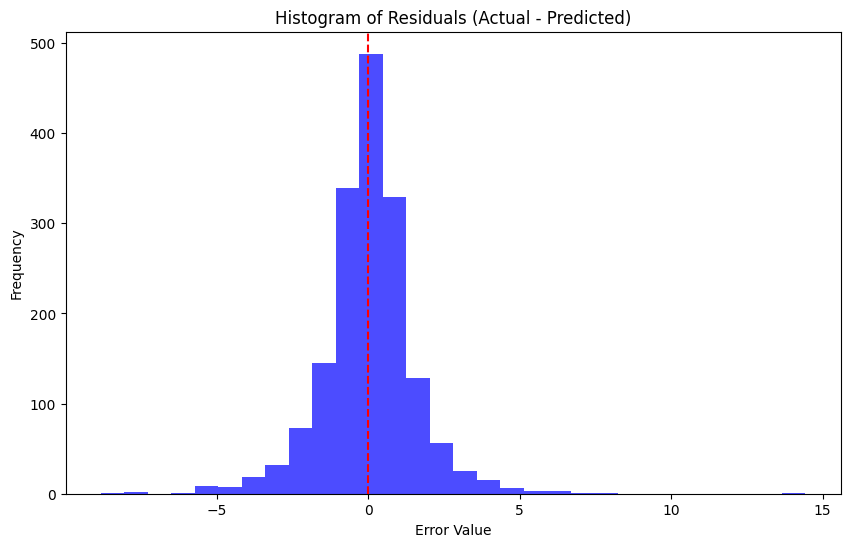

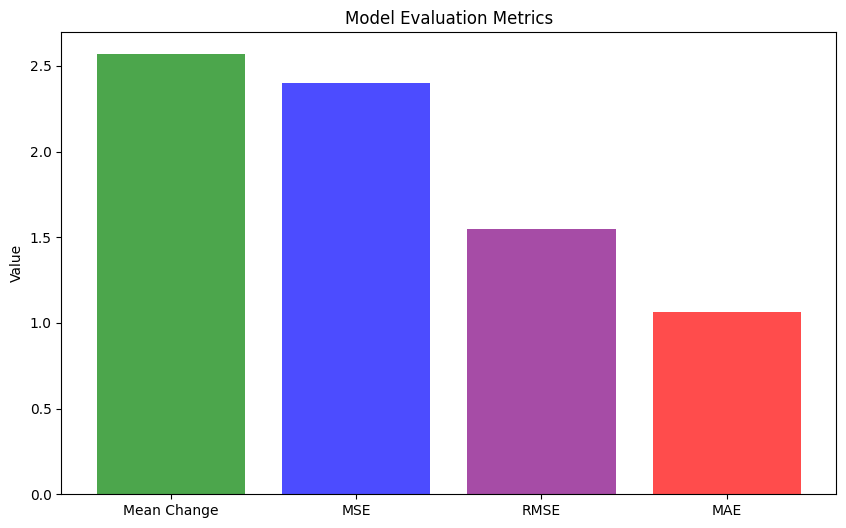

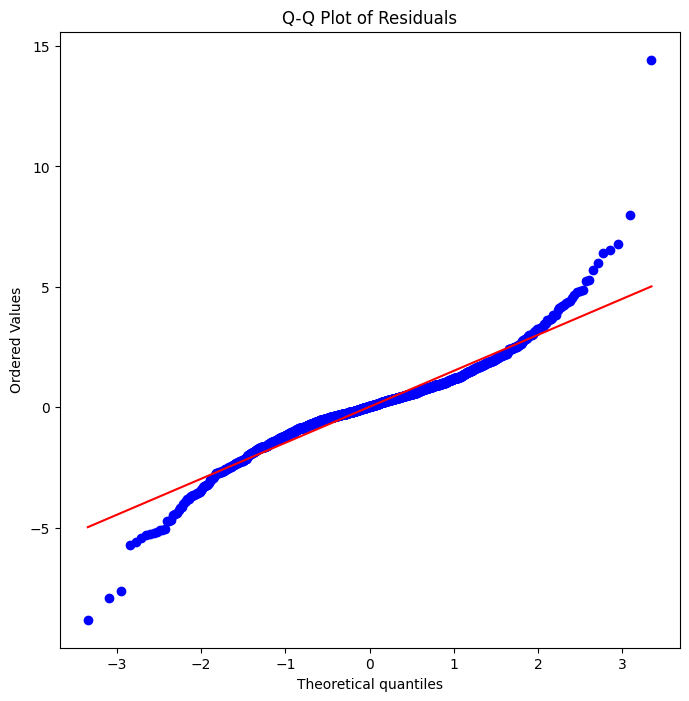

In [5]:
# Cell Four
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the average change
average_change = complete_data['market trend'].mean()

# Convert it to percentage format
average_change_percentage = average_change * 100

print(f"Average daily percentage change in stock prices: {average_change_percentage:.2f}%")

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


import matplotlib.pyplot as plt
import numpy as np

# Residuals
residuals = y_test - y_pred.flatten()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Histogram of Residuals (Actual - Predicted)')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.show()

# Bar chart for metrics
metrics = ['Mean Change', 'MSE', 'RMSE', 'MAE']
values = [average_change_percentage, mse, rmse, mae]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['green', 'blue', 'purple', 'red'], alpha=0.7)
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.show()

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred.ravel()

# Q-Q plot
plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()
